In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import matplotlib.transforms as transforms
import matplotlib.pylab as plt
# import pycbc.pnutils as pnu
import pandas as pd
import numpy as np
import arviz as az
import h5py
import sys
import os

from utilities import *
from scipy.stats import norm
from scipy.special import erf
from matplotlib.patches import Ellipse
from matplotlib.ticker import MaxNLocator
# from pesummary.core.plots.corner import corner

In [16]:
# checking
injectionDict = (
    np.load('../input/injectionDict_O1O2O3O4a_FAR_1_in_1_semianalytic_SNR_10.pickle', allow_pickle=True))
print(len(injectionDict['m1']), len(injectionDict['p_m1_m2_z_a1_a2_costheta1_costheta2']), injectionDict.keys())
print(np.min(injectionDict['m1']), np.max(injectionDict['m2']))

1065931 1065931 dict_keys(['m1', 'm2', 'Xeff', 'Xp', 'z', 'a1', 'a2', 'cost1', 'cost2', 'dVdz', 'p_m1_m2_z_a1_a2_costheta1_costheta2', 'p_m1_m2_z_Xeff_Xp', 'p_m1_m2_z_Xeff', 'mixture_weights', 'nTrials', 'time', 'checksum'])
1.0020050496797077 715.3284873348763


Xeff_N_GP

In [23]:
# data = az.from_netcdf("Xeff_N_GP_O4a.cdf")
data_uni = az.from_netcdf("../output/Xeff_N_uniform_independent_O4a.cdf")
data = az.from_netcdf("../output/Xeff_mixture_O4a.cdf")
# az.summary(data)
az.summary(data)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,5.600,2.697,1.364,10.602,0.076,0.088,1312.0,705.0,NaN
B,0.459,0.449,0.056,1.196,0.034,0.059,114.0,270.0,NaN
C,2.462,0.422,1.667,3.207,0.026,0.016,290.0,514.0,NaN
D,0.194,0.064,0.087,0.289,0.011,0.003,38.0,262.0,NaN
R20,0.226,0.111,0.083,0.457,0.013,0.010,104.0,216.0,NaN
...,...,...,...,...,...,...,...,...,...
p_m1_grid[96],0.000,0.000,0.000,0.000,0.000,0.000,1126.0,952.0,NaN
p_m1_grid[97],0.000,0.000,0.000,0.000,0.000,0.000,1076.0,1056.0,NaN
p_m1_grid[98],0.000,0.000,0.000,0.000,0.000,0.000,1010.0,981.0,NaN
p_m1_grid[99],0.000,0.000,0.000,0.001,0.000,0.000,927.0,1026.0,NaN


In [24]:
stacked_samples = data.posterior.stack(draws=("chain", "draw"))
stacked_samples_conv = az.convert_to_inference_data(stacked_samples)

stacked_samples_uni = data_uni.posterior.stack(draws=("chain", "draw"))
stacked_samples_conv_uni = az.convert_to_inference_data(stacked_samples_uni)

toPlot = {
    "R20": stacked_samples.logR20,
    "mu": stacked_samples.mu_eff_lowM,
    "sigma": stacked_samples.logsig_eff_lowM,
    "logA2": stacked_samples.A,
    "logC2": stacked_samples.C,
    "logB2": stacked_samples.lnB,
    "logD2": stacked_samples.lnD,
    "bq": stacked_samples.bq,
    "min_log_neff": stacked_samples.min_log_neff,
    "nEff_inj": np.log10(stacked_samples.nEff_inj_per_event) }

toPlot_uni = {"mCut2": stacked_samples_uni.mCut,
              "R20": stacked_samples_uni.logR20,
              "mu": stacked_samples_uni.mu_eff,
              "sigma": stacked_samples_uni.logsig_eff,
              "logC2": stacked_samples_uni.C,
              "logD2": stacked_samples_uni.lnD,
              "bq": stacked_samples_uni.bq,
              "min_chi_eff": stacked_samples_uni.min_chi_eff,
              "max_chi_eff": stacked_samples_uni.max_chi_eff,
              "min_log_neff": stacked_samples_uni.min_log_neff,
              "nEff_inj": np.log10(stacked_samples_uni.nEff_inj_per_event) }

toPlot_conv = az.convert_to_inference_data(toPlot_uni)

AttributeError: 'Dataset' object has no attribute 'mCut'

<Figure size 1300x1300 with 0 Axes>

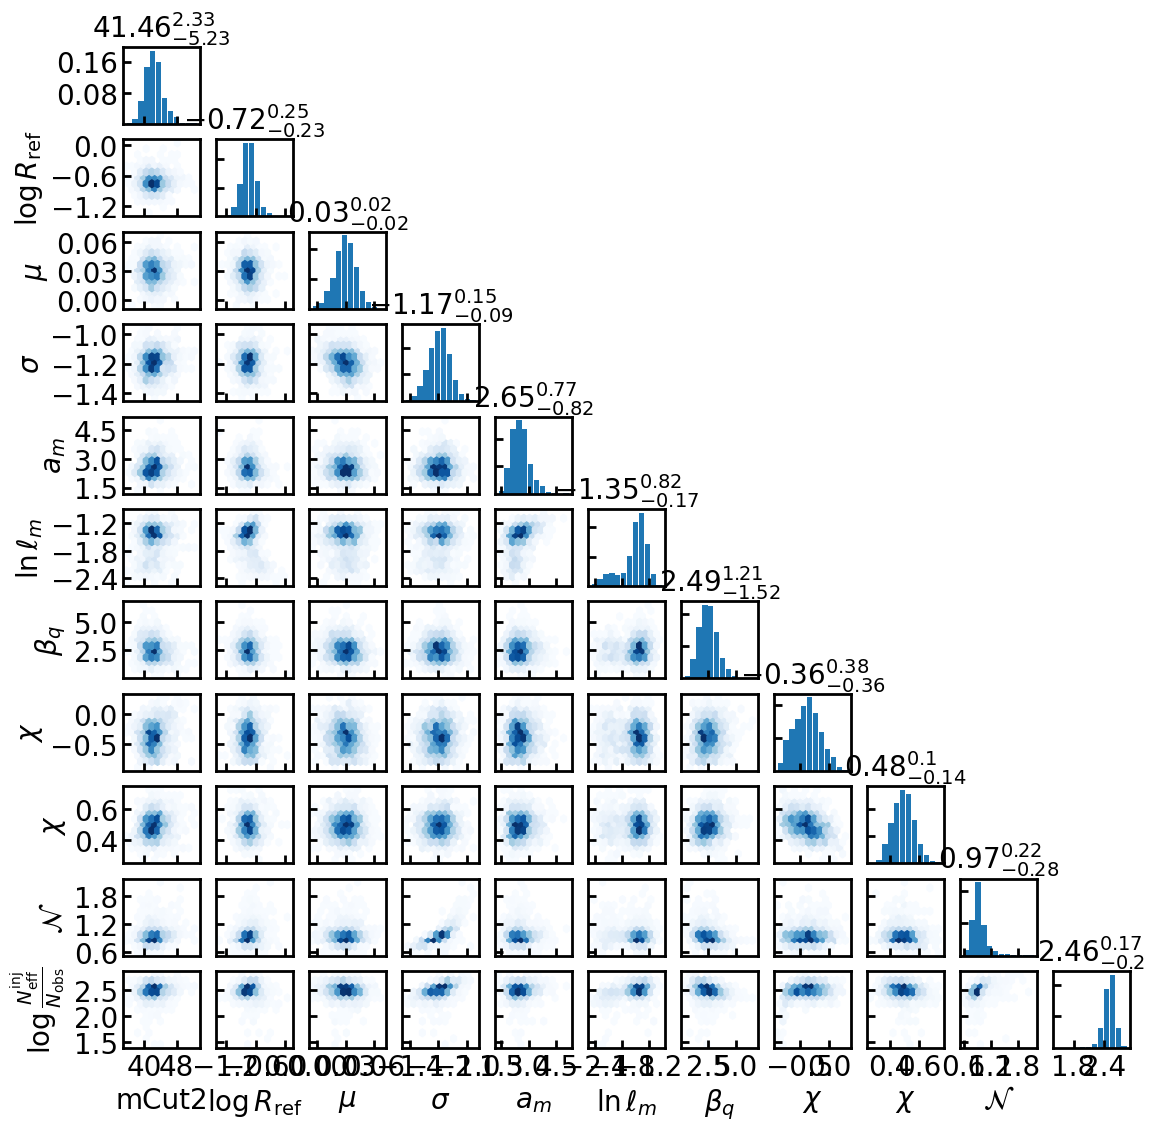

In [22]:
data_plot = toPlot_uni

fig = plt.figure(figsize=(13,13))
az.rcParams["plot.max_subplots"] = 150
axs = az.plot_pair(toPlot,
                  var_names=list(toPlot.keys()),
                  kind='hexbin',
                  marginals=True,
                  hexbin_kwargs={"cmap": "Blues"},
                  marginal_kwargs={"kind": "hist"},
                  figsize=(13,13))

bounds = {"mCut2":{"plot_bounds":(20,90),"label":r"$\tilde{m}$"},
          "R20":{"plot_bounds":(-1.5,1),"label":r"$\log R_{\rm ref}$"},
          "mu":{"plot_bounds":(-0.05,0.2),"label":r"$\mu$"},
          "sigma":{"plot_bounds":(-2,0),"label":r"$\sigma$"},
          "logA2":{"plot_bounds":(-0.1,15),"label":r"$a_\chi$"},
          "logC2":{"plot_bounds":(0.5,5),"label":r"$a_m$"},
          "logB2":{"plot_bounds":(-5,5),"label":r"$\ln \ell_{\chi}$"},
          "logD2":{"plot_bounds":(-3.,-.5),"label":r"$\ln \ell_{m}$"},
          "bq":{"plot_bounds":(-1,5),"label":r"$\beta_q$"},
          "min_log_neff":{"plot_bounds":(0,3),"label":r"$\mathcal{N}$"},
          "nEff_inj":{"plot_bounds":(0,3),"label":r"$\log \frac{N_{\mathrm{eff}}^{\mathrm{inj}}}{N_{\mathrm{obs}}}$"}}

# bounds = {"mCut2":{"plot_bounds":(20,90),"label":r"$\tilde{m}$"},
#           "R20":{"plot_bounds":(-1.5,1),"label":r"$\log R_{\rm ref}$"},
#           "mu":{"plot_bounds":(-0.05,0.2),"label":r"$\mu$"},
#           "sigma":{"plot_bounds":(-2,0),"label":r"$\sigma$"},
#           "logC2":{"plot_bounds":(0.5,5),"label":r"$a_m$"},
#           "logD2":{"plot_bounds":(-3.,-.5),"label":r"$\ln \ell_{m}$"},
#           "bq":{"plot_bounds":(-1,5),"label":r"$\beta_q$"},
#           "min_chi_eff": {"plot_bounds":(-1,1),"label":r"$\chi$"},
#           "max_chi_eff": {"plot_bounds":(-1,1),"label":r"$\chi$"},
#           "min_log_neff":{"plot_bounds":(0,3),"label":r"$\mathcal{N}$"},
#           "nEff_inj":{"plot_bounds":(0,3),"label":r"$\log \frac{N_{\mathrm{eff}}^{\mathrm{inj}}}{N_{\mathrm{obs}}}$"}}

params = list(toPlot.keys())

for i, name_i in enumerate(params):
    for j, name_j in enumerate(params):
        ax = axs[i, j]
        if i == j:
            if i == j == 0:
                ax.set_ylabel("")
            if i == j == 10:
                ax.set_xlabel("")
            if name_i in bounds:
                counts, bins = np.histogram(toPlot[name_j])
                peak = np.argmax(counts)
                peak_value = (bins[peak] + bins[peak+1]) / 2
                CI = np.percentile(toPlot[name_j], [5, 95])
                lo = np.round((CI[1] - peak_value), 2)
                up = np.round((peak_value - CI[0]), 2)
                ax.set_title(f'${np.round(peak_value, 2)}^{{{up}}}_{{{-lo}}}$')
        elif (i == 10 and j != 0) or (i != 0 and j == 0):
            if (i == 10 and j != 0):
                ax.set_xlabel(bounds[name_j]["label"])
            else:
                ax.set_ylabel(bounds[name_i]["label"])
        else:
            ...

        ax.xaxis.set_major_locator(MaxNLocator(nbins=3, prune='both'))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3, prune='both'))

# plt.savefig("Xeff_N_GP_cp.png")

Median total rate: 32.909223374916664
90% CI: [24.82930221 45.28926371]
[8.07992116]
[12.38004034]


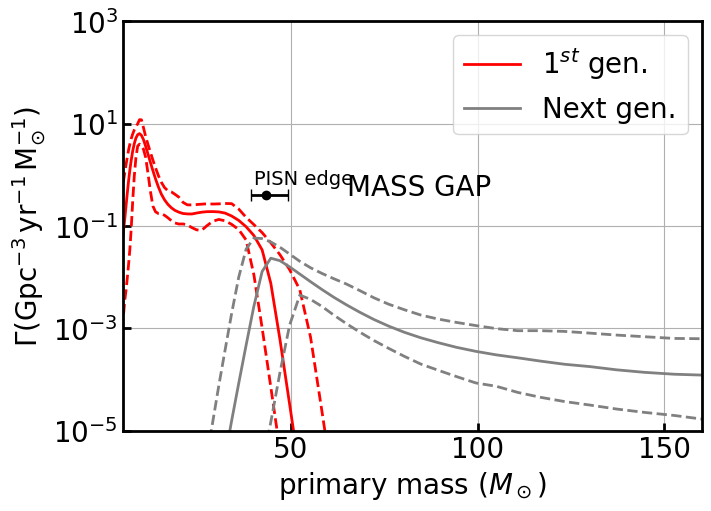

In [11]:
# Matplotlib settings for publication-style plots
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'lines.linewidth': 2,
    'axes.linewidth': 2,
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 1.5,
    'ytick.minor.width': 1.5,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.minor.size': 4,
    'ytick.minor.size': 4,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

# Load posterior samples from ArviZ NetCDF
data = az.from_netcdf("../output/Xeff_N_GP_O4a.cdf")

m1_samples = data.posterior.p_m1_grid.values  # (chains, draws, grid_size)
rate = data.posterior.R20.values              # (chains, draws)
mcut = data.posterior.mCut.values             # (chains, draws)

# Log-mass grid: must match GP setup in the model
m1_grid = np.linspace(0, 2.3, 100)
log_m1 = 10**m1_grid

# Flatten arrays over chains × draws
m1_samples_flat = m1_samples.reshape(-1, 100)  # (samples, grid_size)
rate_flat = rate.reshape(-1)
mcut_flat = mcut.reshape(-1)

# Sanity check
assert m1_samples_flat.shape[0] == rate_flat.shape[0] == mcut_flat.shape[0]

# Mixture fraction: sigmoid function transitioning near mCut
mixture_frac = 1. / (1. + np.exp(-(log_m1[:, None] - mcut_flat) /1))
mixture_frac = mixture_frac.T  # shape: (samples, 100)

# Interpolate at m1 = 20 for each sample
p_20 = np.array([np.interp(np.log10(20), m1_grid, sample) for sample in m1_samples_flat])

# Rescale mass functions
m1_scaled = m1_samples_flat * rate_flat[:, np.newaxis] / p_20[:, np.newaxis] * mixture_frac#*(20/10**m1_grid)
m2_scaled = m1_samples_flat * rate_flat[:, np.newaxis] / p_20[:, np.newaxis] * (1 - mixture_frac)#*(20/10**m1_grid)
mtot = m1_scaled + m2_scaled

# Compute integrated merger rate
rate_integrated = np.trapezoid(mtot, 10**m1_grid, axis=1)

print("Median total rate:", np.median(rate_integrated))
print("90% CI:", np.percentile(rate_integrated, [5, 95]))
print(np.median(rate_integrated)-np.percentile(rate_integrated, [5]))
print(-np.median(rate_integrated)+np.percentile(rate_integrated, [95]))

## Split p(m1) into components for m1 > mCut and m1 < mCut
#m1_scaled = m1_samples_flat * mixture_frac
#m2_scaled = m1_samples_flat * (1 - mixture_frac)
#mtot = m1_scaled + m2_scaled

# Summary statistics (across posterior draws)
def summarize(samples):
    return np.median(samples, axis=0), np.percentile(samples, 5, axis=0), np.percentile(samples, 95, axis=0)

m1_med, m1_lo, m1_hi = summarize(m1_scaled)
m2_med, m2_lo, m2_hi = summarize(m2_scaled)
mtot_med, mtot_lo, mtot_hi = summarize(mtot)

# --- Plot ---
plt.figure(figsize=(7, 5), constrained_layout=True)

#plt.xscale("log")
plt.yscale("log")
plt.xlim(5, 160)
plt.ylim(1e-5, 1000)

# Plot with shaded confidence intervals
def plot_band(x, ymed, ylo, yhi, color, label):
    plt.plot(x, ymed, color=color, label=label)
    plt.plot(x, ylo, color=color, linestyle="--")
    plt.plot(x, yhi, color=color, linestyle="--")

#plot_band(log_m1, m1_med, m1_lo, m1_hi, "grey", r"$m_1 > \tilde{m}$")
#plot_band(log_m1, m2_med, m2_lo, m2_hi, "red", r"$m_1 < \tilde{m}$")
plot_band(log_m1, m2_med, m2_lo, m2_hi, "red", r"$1^{st}$ gen.")
plot_band(log_m1, m1_med, m1_lo, m1_hi, "grey", r"Next gen.")

#plot_band(log_m1, mtot_med, mtot_lo, mtot_hi, "black", "Total")

#plt.text(20, 14, r"$\chi_{\mathrm{eff}}$ and $m_1$ as GP", fontsize=18)
plt.ylabel(r"$\Gamma$(${\rm Gpc^{-3}\,yr^{-1}\,M_{\odot}^{-1}}$)")
plt.xlabel(r"primary mass $(M_\odot)$")

plt.legend()
plt.grid(True)

mcut_med = np.median(mcut_flat)
mcut_mean = np.mean(mcut_flat)
mcut_p10, mcut_p90 = np.percentile(mcut_flat, [10, 90])

# Mid-point on the y-axis (log-scale ⇒ geometric mean)
ax = plt.gca()
ymin, ymax = ax.get_ylim()
y_mid = 10 ** ((np.log10(ymin) + np.log10(ymax)) / 2.0)+0.3

# Horizontal error bar at y_mid
xerr = np.array([[mcut_med - mcut_p10], [mcut_p90 - mcut_med]])
ax.errorbar(mcut_med, y_mid, xerr=xerr, yerr=None,
            fmt='o', color='black', capsize=4, zorder=5,
            label=rf"$\tilde{{m}}$ = {mcut_med:.1f} "
                  rf"[{mcut_p10:.1f}, {mcut_p90:.1f}] (10–90%)")
            #label=rf"$\tilde{{m}}$ = {mcut_med:.1f} "
            #      rf"[{mcut_p10:.1f}, {mcut_p90:.1f}] (10–90%)")
plt.text(40, 0.65, 'PISN edge',size=14)
plt.text(65, 0.4, 'MASS GAP')
#plt.text(
#    15, 15,
#    r"Total rate = $32.7^{+8.3}_{-12.2}\,{\rm Gpc^{-3}\,yr^{-1}}$",size=10
#)

# base transform: data coordinates
base = ax.transData

# add a scale and rotation to the marker
trans = base + transforms.Affine2D().rotate_deg(-45).scale(10, 3)

ax.scatter(
    [40], [0.1],
    marker="o",
    s=5,              # size (adjust)
    facecolors="none",
    edgecolors="blue",
    linewidths=2,
    transform=trans
)

plt.show()
plt.close()

### X_eff plot

In [13]:
# get values
def get_peak(values):
    counts, bins = np.histogram(values)
    peak = np.argmax(counts)
    peak_value = (bins[peak] + bins[peak+1]) / 2
    return peak_value

stacked_samples = data_uni.posterior.stack(draws=("chain", "draw"))
stacked_samples_conv = az.convert_to_inference_data(stacked_samples)

# below PISN gap -> gaussian dist described by mu/sigma params
sig = stacked_samples.logsig_eff.values
mu = stacked_samples.mu_eff.values
n = len(sig)

# above PISN gap -> uniform dist described by min_chi_eff/max_chi_eff params
min_chi_eff = stacked_samples.min_chi_eff.values
max_chi_eff = stacked_samples.max_chi_eff.values
max_chi_eff_peak = get_peak(max_chi_eff)
min_chi_eff_peak = get_peak(min_chi_eff)

# chi_eff bounds
l, h = -1, 1
x = np.linspace(l, h, n)

chi_eff_gaussian, chi_eff_uniform = np.zeros((n, n)), np.zeros((n, n))
for i in range(n):
    chi_eff_gaussian[i,:] = truncatedNormal(x, mu[i], 10**sig[i], l, h)
    chi_eff_uniform[i,:] = smoothlyTruncatedUniform(x, max_chi_eff[i], min_chi_eff[i], 0.05)

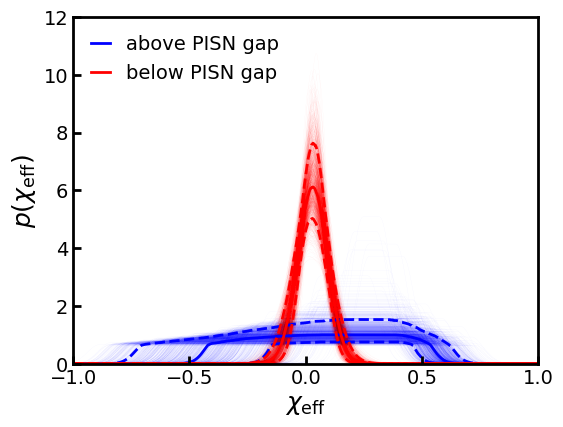

In [14]:
# Plot just the gaussian chi_eff
fig,ax = plt.subplots(figsize=(6,4.5))

ax.plot(x, chi_eff_uniform.T, color='blue', lw=0.1, alpha=0.08, zorder=0)
ax.plot(x, np.quantile(chi_eff_uniform, 0.10, axis=0), color='blue', zorder=1, ls='--')
ax.plot(x, np.quantile(chi_eff_uniform, 0.90, axis=0), color='blue', zorder=1, ls='--')
ax.plot(x, np.median(chi_eff_uniform, axis=0), color='blue', zorder=1, label='above PISN gap')

ax.plot(x, chi_eff_gaussian.T, color='red', lw=0.1, alpha=0.08, zorder=0)
ax.plot(x, np.quantile(chi_eff_gaussian, 0.10, axis=0), color='red', zorder=1, ls='--')
ax.plot(x, np.quantile(chi_eff_gaussian, 0.90, axis=0), color='red', zorder=1, ls='--')
ax.plot(x, np.median(chi_eff_gaussian, axis=0), color='red', zorder=1, label='below PISN gap')
# ax.plot(x, smoothlyTruncatedUniform(x, max_chi_eff_peak, min_chi_eff_peak, 0.05), color='green', zorder=1, label='predicted')

ax.set_xlim(-1, 1)
ax.set_ylim(0, 12)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)
ax.tick_params(axis='both', labelsize=14)

ax.legend(loc='upper left', frameon=False, fontsize=14, handlelength=1)

ax.set_rasterization_zorder(1)
plt.savefig('hmm',bbox_inches='tight',dpi=200)

plt.show()